This notebook aims to contain all the functions that will permit to apply bias correction.

TO DO :

NEED TO CHECK FUNCTIONALITY OF THE CODE for other methods than bscd precipitation
apply cdf for quantile ..
impose a version for the past and for the future (without y test, not used for BC, just for presentation of results)

# BIAS CORRECTION - POINT WISE METHOD

[Scikit-downscale](https://github.com/pangeo-data/scikit-downscale/tree/main)
[Detailed process here](https://github.com/pangeo-data/scikit-downscale/blob/main/examples/2020ECAHM-scikit-downscale.ipynb)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


import numpy as np
import pandas as pd
import scipy
import xarray as xr
import os
import os.path

import warnings
warnings.filterwarnings("ignore")  # sklearn

import matplotlib.pyplot as plt
import seaborn as sns



# exploratory data analysis for arrm model
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
# train_test_split Quick utility that wraps input validation and
#    ``next(ShuffleSplit().split(X, y))`` and application to input data
#    into a single call for splitting (and optionally subsampling) data in a
#    oneliner.
#    Returns
#    -------
#    splitting : list, length=2 * len(arrays)
#        List containing train-test split of inputs.

#        .. versionadded:: 0.16
#            If the input is sparse, the output will be a
#            ``scipy.sparse.csr_matrix``. Else, output type is the same as the
#            input type.

#from utils import get_sample_data

from sklearn.preprocessing import KBinsDiscretizer
# use for discretization

sns.set(style='darkgrid')

In [2]:
# df_obs and df_model should be under a dataframe format, with no nan values, with a common timelaps, with the data as a string format '%Y-%m-%d', and as index

# Method could be :
#        QuantileTransformer
#        

def BC(df_obs,df_model,method):
    # prepare data
    training = df_model.copy(deep=True)
    targets = df_obs.copy(deep=True)
    df=pd.concat({'training': training, 'targets': targets}, axis=1)
    df=df.dropna()
    
    X = df[['training']].values#['1980': '2014']#training[['pcp']]['1980': '2014'].values
    y = df[['targets']].values# targets[['pcp']]['1980': '2014'].values

    return

In [3]:
def piecewise_regressor(X,y):
    from mlinsights.mlmodel import PiecewiseRegressor # in piecewise estimator
    #     Uses a :epkg:`decision tree` to split the space of features
    #    into buckets and trains a linear regression (default) on each of them.
    #    The second estimator is usually a :epkg:`sklearn:linear_model:LinearRegression`.
    #    It can also be :epkg:`sklearn:dummy:DummyRegressor` to just get
    #    the average on each bucket.
    
    X_train, X_test, y_train, y_test = train_test_split(X, y)# splits data
    
    # parameters for Quantile transforms
    qqwargs = {'n_quantiles': int(1e6), 'copy': True, 'subsample': int(1e6)} # add int for n_quantiles and subsample to avoid
    # following problem:  InvalidParameterError: The 'n_quantiles' parameter of QuantileTransformer must be an int in the range [1, inf). Got 1000000.0 instead.
    n_bins = 7
    
    y_train = y_train[:, 0]
    
    score_strat =[]
    name_strat = ['kmeans', 'uniform', 'quantile']
    for strat in name_strat:
        model = PiecewiseRegressor(binner=KBinsDiscretizer(n_bins=n_bins, strategy=strat))
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        score_strat.append(model.score(X_test, y_test))
        # how is the score calculated ? r2 score
    
    model = PiecewiseRegressor(binner=KBinsDiscretizer(n_bins=n_bins, strategy=name_strat[np.where(score_strat == min(score_strat))[0]]))
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    return X_train, X_test, y_train, y_test,pred

In [4]:
def Quantile_Linear_Regression(X,y):
    from mlinsights.mlmodel import QuantileLinearRegression # in quantile_regression
    
    X_train, X_test, y_train, y_test = train_test_split(X, y)# splits data

    model = QuantileLinearRegression()
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    print(model.score(X_test, y_test))# mean absolute error
    return

In [5]:
def BCSD_Precipitation(df):
    from skdownscale.pointwise_models import BcsdPrecipitation
    X_train = df[['training']].iloc[0:round(len(df.index)/2)]
    X_test = df[['training']].iloc[round(len(df.index)/2)+1:len(df.index)]
    y_train = df[['targets']].iloc[0:round(len(df.index)/2)]
    y_test = df[['targets']].iloc[round(len(df.index)/2)+1:len(df.index)]
    
    X_train.index = pd.to_datetime(X_train.index)
    y_train.index = pd.to_datetime(y_train.index)
    X_test.index = pd.to_datetime(X_test.index)
    y_test.index = pd.to_datetime(y_test.index)
    print(X_train)
    print(X_test)
    print(y_train)
    print(y_test)
    
    # Fit/predict the BCSD Temperature model
    bcsd_temp = BcsdPrecipitation()
    bcsd_temp.fit(X_train, y_train)
    out = bcsd_temp.predict(X_test) + X_test
    
    plot_train_test(X_train, X_test, y_train, y_test)
    plot_train_test_pred(X_train, X_test, y_train, y_test,out)
    plot_test_pred(X_test,y_test, y_train, out)
    
    out = plot_cdfs(X_test,y_test,out)
    
    return out

In [6]:
def BCSD_Precipitation_one_more_time(df,out):
    
    df=df.loc[out.index]
    df['training'] = out['pcp']
    print(df)
    out = BCSD_Precipitation(df)
    
    return out

In [7]:
def BCSD_Temperature(df1):
    from skdownscale.pointwise_models import BcsdTemperature
    X_train = df1[['training']].loc['1970-01-01':'1990-01-01']
    X_test = df1[['training']].loc['1990-01-01':'2010-01-01']
    y_train = df1[['targets']].loc['1970-01-01':'1990-01-01']
    y_test = df1[['targets']].loc['1990-01-01':'2010-01-01']    
    
    X_train.index = pd.to_datetime(X_train.index)
    y_train.index = pd.to_datetime(y_train.index)
    X_test.index = pd.to_datetime(X_test.index)
    y_test.index = pd.to_datetime(y_test.index)
    return

In [8]:
# plot results

def plot_train_test(X_train, X_test, y_train, y_test):
    sns.set(style='whitegrid')
    c = {'train': 'black', 'predict': 'blue', 'test': 'grey'}
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    plt.scatter(X_train, y_train, c=c['train'], s=5, label='train')
    plt.scatter(X_test, y_test, c=c['test'], s=5, label='test')
    plt.title('Train and test data')
    plt.xlabel('modeled data')
    plt.ylabel('observed data')
    ax.legend()
    return

def plot_train_test_pred(X_train, X_test, y_train, y_test,pred):
    sns.set(style='whitegrid')
    c = {'train': 'black', 'predict': 'blue', 'test': 'grey'}
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    plt.scatter(np.sort(X_train, axis=0), np.sort(y_train, axis=0), c=c['train'], s=5, label='train')
    plt.scatter(np.sort(X_test, axis=0), np.sort(y_test, axis=0), c=c['test'], s=5, label='test')
    plt.plot(np.sort(X_test, axis=0), np.sort(pred, axis=0), c=c['predict'], lw=2, label='predictions')
    plt.title('Sorted train and test data')
    plt.xlabel('modeled data')
    plt.ylabel('observed data and prediction')
    ax.legend()
    return
    
def plot_test_pred(X_test,y_test, y_train, pred):
    sns.set(style='whitegrid')
    c = {'train': 'black', 'predict': 'blue', 'test': 'grey'}

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    #ax.plot(X_test[:, 0], y_test, ".", label='data', c=c['test'])
    #ax.plot(X_test[:, 0], pred, ".", label="predictions", c=c['predict'])
    ax.plot(X_test, y_test, ".", label='data', c=c['test'])
    ax.plot(X_test, pred, ".", label="predictions", c=c['predict'])
    #ax.set_title(f"Piecewise Linear Regression\n{n_bins} buckets")
    plt.title('Test data and prediction')
    plt.xlabel('modeled data')
    plt.ylabel('observed data and prediction')
    ax.legend()
    return


def plot_cdfs(X_test,y_test,out):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    plot_cdf(X=X_test, y=y_test, out=out)
    out.plot()
    out=out.rename(columns={'training':'pcp'})
    
    plot_cdf_by_month(X=X_test, y=y_test.loc[list(X_test.index)], out=out)
    
    out.index = out.index.strftime('%Y-%m-%d')
    
    # make a plot of the temperature and precipitation data
    fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(8, 3), sharex=True)
    time_slice = slice('1990-01-01', '1990-12-31')

    targets[time_slice]['pcp'].plot(label='targets')
    out[time_slice]['pcp'].plot(label='out')
    training[time_slice]['pcp'].plot(label='training')
    axes.legend()
    axes.set_ylabel('Precipitation [mm/day]')
    # make a plot of the temperature and precipitation data
    
    
    fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(8, 9), sharex=True)
    time_slice = slice('1990-01-01', '1990-12-31')

    # plot-temperature
    training[time_slice]['pcp'].plot(ax=axes[0], label='training')
    axes[0].legend()
    axes[0].set_ylabel('Precipitation [mm/day]')
    axes[0].set_ylim(0,250)


    # plot-precipitation
    targets[time_slice]['pcp'].plot(ax=axes[1], label='target')
    axes[1].legend()
    _ = axes[1].set_ylabel('Precipitation [mm/day]')
    axes[1].set_ylim(0,250)

    # plot-precipitation
    out[time_slice]['pcp'].plot(ax=axes[2], label='out')
    axes[2].legend()
    _ = axes[2].set_ylabel('Precipitation [mm/day]')
    axes[2].set_ylim(0,250)
    
    return out

# utilities for plotting cdfs
# those are pdf not cdf 
def plot_cdf(ax=None, **kwargs):
    if ax:
        plt.sca(ax)
    else:
        ax = plt.gca()

    for label, X in kwargs.items():
        vals = np.sort(X, axis=0)
        pp = scipy.stats.mstats.plotting_positions(vals)
        ax.plot(pp, vals, label=label)
    ax.legend()
    return ax


def plot_cdf_by_month(ax=None, **kwargs):
    fig, axes = plt.subplots(4, 3, sharex=True, sharey=False, figsize=(12, 8))

    for label, X in kwargs.items():
        for month, ax in zip(range(1, 13), axes.flat):

            vals = np.sort(X[X.index.month == month], axis=0)
            pp = scipy.stats.mstats.plotting_positions(vals)
            ax.plot(pp, vals, label=label)
            ax.set_title(month)
    ax.legend()
    return ax

In [9]:
# import data

In [10]:
def import_treat_modeled_NEX_GDDP_CMIP6(climate_var):
    # import data
    #path_NEX_GDDP_CMIP6_EmplacementStation = r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets\NEX-GDDP-CMIP6-AllMoz\csv_file\'+climate_var+'\pr_mm_per_day_day_1970-2014\Station_at_same_emplacement_as_NOAA_stationBeiraPembaChimoio_pr_1970-2014_projectsMoz.csv'
    #out_path = r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets\NEX-GDDP-CMIP6-AllMoz\csv_file'
    if climate_var =='pr':
        path_NEX_GDDP_CMIP6_EmplacementStation=os.path.join(r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets\NEX-GDDP-CMIP6-AllMoz\csv_file',climate_var,climate_var+'_mm_per_day_day_1970-2014_Closest_to_NOAA','NEXGDDPCMIP6_at_same_emplacement_as_NOAA_stationPembaChimoioBeira_'+climate_var+'_1970-2014_projectsMoz.csv')
    else: # temperature
        path_NEX_GDDP_CMIP6_EmplacementStation=os.path.join(r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets\NEX-GDDP-CMIP6-AllMoz\csv_file',climate_var,climate_var+'_Celsius_day_1970-2014_Closest_to_NOAA','NEXGDDPCMIP6_at_same_emplacement_as_NOAA_stationPembaChimoioBeira_'+climate_var+'_1970-2014_projectsMoz.csv')
        
    data_NEX_GDDP_CMIP6_EmplacementStation = pd.read_csv(path_NEX_GDDP_CMIP6_EmplacementStation)
    data_NEX_GDDP_CMIP6_EmplacementStation = data_NEX_GDDP_CMIP6_EmplacementStation.drop(['Experiment','Latitude','Longitude'],axis=1)
    
    # add Year, month and season columns for graphs
    Year = data_NEX_GDDP_CMIP6_EmplacementStation[['Date']].values.reshape(len(data_NEX_GDDP_CMIP6_EmplacementStation[['Date']].values),)
    Month = data_NEX_GDDP_CMIP6_EmplacementStation[['Date']].values.reshape(len(data_NEX_GDDP_CMIP6_EmplacementStation[['Date']].values),)
    Season = data_NEX_GDDP_CMIP6_EmplacementStation[['Date']].values.reshape(len(data_NEX_GDDP_CMIP6_EmplacementStation[['Date']].values),)
    
    for i in np.arange(0,len(data_NEX_GDDP_CMIP6_EmplacementStation[['Date']].values)):
        Year[i]=int(Year[i][6:10])
        Month[i]=int(Month[i][3:5])
        if int(Month[i])>3 and int(Month[i])<10: # dry season in Mozambique is between April and September
            Season[i]='Dry'
        else:# humid season is between October and March
            Season[i]='Humid'

    data_NEX_GDDP_CMIP6_EmplacementStation['Year'] = Year
    data_NEX_GDDP_CMIP6_EmplacementStation['Month'] = Month
    data_NEX_GDDP_CMIP6_EmplacementStation['Season'] = Season
    
    return data_NEX_GDDP_CMIP6_EmplacementStation

In [11]:
# this function is meant to import the NOAA observation data
def import_treat_obs_NOAA():
    # path where the file is placed
    path_file_NOAA = r'C:\Users\CLMRX\COWI\A248363 - Climate analysis - Documents\General\CRVA_tool\Master_thesis\Project\3 - Implementation\1 - Data\1-BC\NOAA-ClimateDataOnline\3370204.csv'
    # read the information in the file
    data_obs_NOAA = pd.read_csv(path_file_NOAA)
    # unit of PRCP are mm
    # unit of temperature are degrees Celsius
    
    # add Year, month and season columns for graphs
    Year = data_obs_NOAA[['DATE']].values.reshape(len(data_obs_NOAA[['DATE']].values),)
    Month = data_obs_NOAA[['DATE']].values.reshape(len(data_obs_NOAA[['DATE']].values),)
    Season = data_obs_NOAA[['DATE']].values.reshape(len(data_obs_NOAA[['DATE']].values),)
    for i in np.arange(0,len(data_obs_NOAA[['DATE']].values)):
        Year[i]=int(Year[i][0:4])
        Month[i]=int(Month[i][5:7])
        if int(Month[i])>3 and int(Month[i])<10: # dry season in Mozambique is between April and September
            Season[i]='Dry'
        else:# humid season is between October and March
            Season[i]='Humid'

    data_obs_NOAA['Year'] = Year
    data_obs_NOAA['Month'] = Month
    data_obs_NOAA['Season'] = Season
    return data_obs_NOAA

In [12]:
climate_var = 'pr' # 'tas'

# precipitation : 'pr'

name_station = 'BEIRA, MZ'

In [13]:
climate_var_NEX_GDDP_CMIP6_EmplacementStation=import_treat_modeled_NEX_GDDP_CMIP6(climate_var)
data_obs_NOAA=import_treat_obs_NOAA()

In [14]:
climate_var_NEX_GDDP_CMIP6_EmplacementStation_BC=climate_var_NEX_GDDP_CMIP6_EmplacementStation[climate_var_NEX_GDDP_CMIP6_EmplacementStation['Name station']==name_station].drop(['Name station','Year','Month','Season'],axis =1)
climate_var_NEX_GDDP_CMIP6_EmplacementStation_BC_model = climate_var_NEX_GDDP_CMIP6_EmplacementStation_BC[climate_var_NEX_GDDP_CMIP6_EmplacementStation_BC['Model'] =='ACCESS-CM2'].drop(['Model'],axis=1)
training = climate_var_NEX_GDDP_CMIP6_EmplacementStation_BC_model.rename(columns = {'Date':'time','Mean of the daily precipitation rate mm/day':'pcp'}).reset_index()

# changing format of Date for training
Date1 = training['time'].values
for i in np.arange(0,len(training)):
    training['time'][i] = Date1[i][6:10]+'-'+Date1[i][3:5]+'-'+Date1[i][0:2]#datetime.strptime(, '%Y-%M-%d').date()
    print(training['time'][i])
# .date() to avoid having the hours in the datetime
training=training.set_index('time').drop(['index'],axis=1)


# targets
targets = data_obs_NOAA[['NAME','DATE','PRCP']] # select only 3 columns of interest
targets = targets[targets['NAME']==name_station].rename(columns = {'DATE':'time','PRCP':'pcp'}).set_index('time').drop(['NAME'],axis=1) # the targets data is meant to represent our "observations"


# to have the same size of vectors
targets = targets.dropna() # drop rows with NaN
training = training[training.index.isin(list(targets.index))]

1970-01-01
1970-01-02
1970-01-03
1970-01-04
1970-01-05
1970-01-06
1970-01-07
1970-01-08
1970-01-09
1970-01-10
1970-01-11
1970-01-12
1970-01-13
1970-01-14
1970-01-15
1970-01-16
1970-01-17
1970-01-18
1970-01-19
1970-01-20
1970-01-21
1970-01-22
1970-01-23
1970-01-24
1970-01-25
1970-01-26
1970-01-27
1970-01-28
1970-01-29
1970-01-30
1970-01-31
1970-02-01
1970-02-02
1970-02-03
1970-02-04
1970-02-05
1970-02-06
1970-02-07
1970-02-08
1970-02-09
1970-02-10
1970-02-11
1970-02-12
1970-02-13
1970-02-14
1970-02-15
1970-02-16
1970-02-17
1970-02-18
1970-02-19
1970-02-20
1970-02-21
1970-02-22
1970-02-23
1970-02-24
1970-02-25
1970-02-26
1970-02-27
1970-02-28
1970-03-01
1970-03-02
1970-03-03
1970-03-04
1970-03-05
1970-03-06
1970-03-07
1970-03-08
1970-03-09
1970-03-10
1970-03-11
1970-03-12
1970-03-13
1970-03-14
1970-03-15
1970-03-16
1970-03-17
1970-03-18
1970-03-19
1970-03-20
1970-03-21
1970-03-22
1970-03-23
1970-03-24
1970-03-25
1970-03-26
1970-03-27
1970-03-28
1970-03-29
1970-03-30
1970-03-31
1970-04-01

1974-06-19
1974-06-20
1974-06-21
1974-06-22
1974-06-23
1974-06-24
1974-06-25
1974-06-26
1974-06-27
1974-06-28
1974-06-29
1974-06-30
1974-07-01
1974-07-02
1974-07-03
1974-07-04
1974-07-05
1974-07-06
1974-07-07
1974-07-08
1974-07-09
1974-07-10
1974-07-11
1974-07-12
1974-07-13
1974-07-14
1974-07-15
1974-07-16
1974-07-17
1974-07-18
1974-07-19
1974-07-20
1974-07-21
1974-07-22
1974-07-23
1974-07-24
1974-07-25
1974-07-26
1974-07-27
1974-07-28
1974-07-29
1974-07-30
1974-07-31
1974-08-01
1974-08-02
1974-08-03
1974-08-04
1974-08-05
1974-08-06
1974-08-07
1974-08-08
1974-08-09
1974-08-10
1974-08-11
1974-08-12
1974-08-13
1974-08-14
1974-08-15
1974-08-16
1974-08-17
1974-08-18
1974-08-19
1974-08-20
1974-08-21
1974-08-22
1974-08-23
1974-08-24
1974-08-25
1974-08-26
1974-08-27
1974-08-28
1974-08-29
1974-08-30
1974-08-31
1974-09-01
1974-09-02
1974-09-03
1974-09-04
1974-09-05
1974-09-06
1974-09-07
1974-09-08
1974-09-09
1974-09-10
1974-09-11
1974-09-12
1974-09-13
1974-09-14
1974-09-15
1974-09-16
1974-09-17

1978-08-06
1978-08-07
1978-08-08
1978-08-09
1978-08-10
1978-08-11
1978-08-12
1978-08-13
1978-08-14
1978-08-15
1978-08-16
1978-08-17
1978-08-18
1978-08-19
1978-08-20
1978-08-21
1978-08-22
1978-08-23
1978-08-24
1978-08-25
1978-08-26
1978-08-27
1978-08-28
1978-08-29
1978-08-30
1978-08-31
1978-09-01
1978-09-02
1978-09-03
1978-09-04
1978-09-05
1978-09-06
1978-09-07
1978-09-08
1978-09-09
1978-09-10
1978-09-11
1978-09-12
1978-09-13
1978-09-14
1978-09-15
1978-09-16
1978-09-17
1978-09-18
1978-09-19
1978-09-20
1978-09-21
1978-09-22
1978-09-23
1978-09-24
1978-09-25
1978-09-26
1978-09-27
1978-09-28
1978-09-29
1978-09-30
1978-10-01
1978-10-02
1978-10-03
1978-10-04
1978-10-05
1978-10-06
1978-10-07
1978-10-08
1978-10-09
1978-10-10
1978-10-11
1978-10-12
1978-10-13
1978-10-14
1978-10-15
1978-10-16
1978-10-17
1978-10-18
1978-10-19
1978-10-20
1978-10-21
1978-10-22
1978-10-23
1978-10-24
1978-10-25
1978-10-26
1978-10-27
1978-10-28
1978-10-29
1978-10-30
1978-10-31
1978-11-01
1978-11-02
1978-11-03
1978-11-04

1986-04-25
1986-04-26
1986-04-27
1986-04-28
1986-04-29
1986-04-30
1986-05-01
1986-05-02
1986-05-03
1986-05-04
1986-05-05
1986-05-06
1986-05-07
1986-05-08
1986-05-09
1986-05-10
1986-05-11
1986-05-12
1986-05-13
1986-05-14
1986-05-15
1986-05-16
1986-05-17
1986-05-18
1986-05-19
1986-05-20
1986-05-21
1986-05-22
1986-05-23
1986-05-24
1986-05-25
1986-05-26
1986-05-27
1986-05-28
1986-05-29
1986-05-30
1986-05-31
1986-06-01
1986-06-02
1986-06-03
1986-06-04
1986-06-05
1986-06-06
1986-06-07
1986-06-08
1986-06-09
1986-06-10
1986-06-11
1986-06-12
1986-06-13
1986-06-14
1986-06-15
1986-06-16
1986-06-17
1986-06-18
1986-06-19
1986-06-20
1986-06-21
1986-06-22
1986-06-23
1986-06-24
1986-06-25
1986-06-26
1986-06-27
1986-06-28
1986-06-29
1986-06-30
1986-07-01
1986-07-02
1986-07-03
1986-07-04
1986-07-05
1986-07-06
1986-07-07
1986-07-08
1986-07-09
1986-07-10
1986-07-11
1986-07-12
1986-07-13
1986-07-14
1986-07-15
1986-07-16
1986-07-17
1986-07-18
1986-07-19
1986-07-20
1986-07-21
1986-07-22
1986-07-23
1986-07-24

1995-02-28
1995-03-01
1995-03-02
1995-03-03
1995-03-04
1995-03-05
1995-03-06
1995-03-07
1995-03-08
1995-03-09
1995-03-10
1995-03-11
1995-03-12
1995-03-13
1995-03-14
1995-03-15
1995-03-16
1995-03-17
1995-03-18
1995-03-19
1995-03-20
1995-03-21
1995-03-22
1995-03-23
1995-03-24
1995-03-25
1995-03-26
1995-03-27
1995-03-28
1995-03-29
1995-03-30
1995-03-31
1995-04-01
1995-04-02
1995-04-03
1995-04-04
1995-04-05
1995-04-06
1995-04-07
1995-04-08
1995-04-09
1995-04-10
1995-04-11
1995-04-12
1995-04-13
1995-04-14
1995-04-15
1995-04-16
1995-04-17
1995-04-18
1995-04-19
1995-04-20
1995-04-21
1995-04-22
1995-04-23
1995-04-24
1995-04-25
1995-04-26
1995-04-27
1995-04-28
1995-04-29
1995-04-30
1995-05-01
1995-05-02
1995-05-03
1995-05-04
1995-05-05
1995-05-06
1995-05-07
1995-05-08
1995-05-09
1995-05-10
1995-05-11
1995-05-12
1995-05-13
1995-05-14
1995-05-15
1995-05-16
1995-05-17
1995-05-18
1995-05-19
1995-05-20
1995-05-21
1995-05-22
1995-05-23
1995-05-24
1995-05-25
1995-05-26
1995-05-27
1995-05-28
1995-05-29

1998-03-27
1998-03-28
1998-03-29
1998-03-30
1998-03-31
1998-04-01
1998-04-02
1998-04-03
1998-04-04
1998-04-05
1998-04-06
1998-04-07
1998-04-08
1998-04-09
1998-04-10
1998-04-11
1998-04-12
1998-04-13
1998-04-14
1998-04-15
1998-04-16
1998-04-17
1998-04-18
1998-04-19
1998-04-20
1998-04-21
1998-04-22
1998-04-23
1998-04-24
1998-04-25
1998-04-26
1998-04-27
1998-04-28
1998-04-29
1998-04-30
1998-05-01
1998-05-02
1998-05-03
1998-05-04
1998-05-05
1998-05-06
1998-05-07
1998-05-08
1998-05-09
1998-05-10
1998-05-11
1998-05-12
1998-05-13
1998-05-14
1998-05-15
1998-05-16
1998-05-17
1998-05-18
1998-05-19
1998-05-20
1998-05-21
1998-05-22
1998-05-23
1998-05-24
1998-05-25
1998-05-26
1998-05-27
1998-05-28
1998-05-29
1998-05-30
1998-05-31
1998-06-01
1998-06-02
1998-06-03
1998-06-04
1998-06-05
1998-06-06
1998-06-07
1998-06-08
1998-06-09
1998-06-10
1998-06-11
1998-06-12
1998-06-13
1998-06-14
1998-06-15
1998-06-16
1998-06-17
1998-06-18
1998-06-19
1998-06-20
1998-06-21
1998-06-22
1998-06-23
1998-06-24
1998-06-25

2002-06-11
2002-06-12
2002-06-13
2002-06-14
2002-06-15
2002-06-16
2002-06-17
2002-06-18
2002-06-19
2002-06-20
2002-06-21
2002-06-22
2002-06-23
2002-06-24
2002-06-25
2002-06-26
2002-06-27
2002-06-28
2002-06-29
2002-06-30
2002-07-01
2002-07-02
2002-07-03
2002-07-04
2002-07-05
2002-07-06
2002-07-07
2002-07-08
2002-07-09
2002-07-10
2002-07-11
2002-07-12
2002-07-13
2002-07-14
2002-07-15
2002-07-16
2002-07-17
2002-07-18
2002-07-19
2002-07-20
2002-07-21
2002-07-22
2002-07-23
2002-07-24
2002-07-25
2002-07-26
2002-07-27
2002-07-28
2002-07-29
2002-07-30
2002-07-31
2002-08-01
2002-08-02
2002-08-03
2002-08-04
2002-08-05
2002-08-06
2002-08-07
2002-08-08
2002-08-09
2002-08-10
2002-08-11
2002-08-12
2002-08-13
2002-08-14
2002-08-15
2002-08-16
2002-08-17
2002-08-18
2002-08-19
2002-08-20
2002-08-21
2002-08-22
2002-08-23
2002-08-24
2002-08-25
2002-08-26
2002-08-27
2002-08-28
2002-08-29
2002-08-30
2002-08-31
2002-09-01
2002-09-02
2002-09-03
2002-09-04
2002-09-05
2002-09-06
2002-09-07
2002-09-08
2002-09-09

2005-08-21
2005-08-22
2005-08-23
2005-08-24
2005-08-25
2005-08-26
2005-08-27
2005-08-28
2005-08-29
2005-08-30
2005-08-31
2005-09-01
2005-09-02
2005-09-03
2005-09-04
2005-09-05
2005-09-06
2005-09-07
2005-09-08
2005-09-09
2005-09-10
2005-09-11
2005-09-12
2005-09-13
2005-09-14
2005-09-15
2005-09-16
2005-09-17
2005-09-18
2005-09-19
2005-09-20
2005-09-21
2005-09-22
2005-09-23
2005-09-24
2005-09-25
2005-09-26
2005-09-27
2005-09-28
2005-09-29
2005-09-30
2005-10-01
2005-10-02
2005-10-03
2005-10-04
2005-10-05
2005-10-06
2005-10-07
2005-10-08
2005-10-09
2005-10-10
2005-10-11
2005-10-12
2005-10-13
2005-10-14
2005-10-15
2005-10-16
2005-10-17
2005-10-18
2005-10-19
2005-10-20
2005-10-21
2005-10-22
2005-10-23
2005-10-24
2005-10-25
2005-10-26
2005-10-27
2005-10-28
2005-10-29
2005-10-30
2005-10-31
2005-11-01
2005-11-02
2005-11-03
2005-11-04
2005-11-05
2005-11-06
2005-11-07
2005-11-08
2005-11-09
2005-11-10
2005-11-11
2005-11-12
2005-11-13
2005-11-14
2005-11-15
2005-11-16
2005-11-17
2005-11-18
2005-11-19

2010-05-25
2010-05-26
2010-05-27
2010-05-28
2010-05-29
2010-05-30
2010-05-31
2010-06-01
2010-06-02
2010-06-03
2010-06-04
2010-06-05
2010-06-06
2010-06-07
2010-06-08
2010-06-09
2010-06-10
2010-06-11
2010-06-12
2010-06-13
2010-06-14
2010-06-15
2010-06-16
2010-06-17
2010-06-18
2010-06-19
2010-06-20
2010-06-21
2010-06-22
2010-06-23
2010-06-24
2010-06-25
2010-06-26
2010-06-27
2010-06-28
2010-06-29
2010-06-30
2010-07-01
2010-07-02
2010-07-03
2010-07-04
2010-07-05
2010-07-06
2010-07-07
2010-07-08
2010-07-09
2010-07-10
2010-07-11
2010-07-12
2010-07-13
2010-07-14
2010-07-15
2010-07-16
2010-07-17
2010-07-18
2010-07-19
2010-07-20
2010-07-21
2010-07-22
2010-07-23
2010-07-24
2010-07-25
2010-07-26
2010-07-27
2010-07-28
2010-07-29
2010-07-30
2010-07-31
2010-08-01
2010-08-02
2010-08-03
2010-08-04
2010-08-05
2010-08-06
2010-08-07
2010-08-08
2010-08-09
2010-08-10
2010-08-11
2010-08-12
2010-08-13
2010-08-14
2010-08-15
2010-08-16
2010-08-17
2010-08-18
2010-08-19
2010-08-20
2010-08-21
2010-08-22
2010-08-23

2014-01-18
2014-01-19
2014-01-20
2014-01-21
2014-01-22
2014-01-23
2014-01-24
2014-01-25
2014-01-26
2014-01-27
2014-01-28
2014-01-29
2014-01-30
2014-01-31
2014-02-01
2014-02-02
2014-02-03
2014-02-04
2014-02-05
2014-02-06
2014-02-07
2014-02-08
2014-02-09
2014-02-10
2014-02-11
2014-02-12
2014-02-13
2014-02-14
2014-02-15
2014-02-16
2014-02-17
2014-02-18
2014-02-19
2014-02-20
2014-02-21
2014-02-22
2014-02-23
2014-02-24
2014-02-25
2014-02-26
2014-02-27
2014-02-28
2014-03-01
2014-03-02
2014-03-03
2014-03-04
2014-03-05
2014-03-06
2014-03-07
2014-03-08
2014-03-09
2014-03-10
2014-03-11
2014-03-12
2014-03-13
2014-03-14
2014-03-15
2014-03-16
2014-03-17
2014-03-18
2014-03-19
2014-03-20
2014-03-21
2014-03-22
2014-03-23
2014-03-24
2014-03-25
2014-03-26
2014-03-27
2014-03-28
2014-03-29
2014-03-30
2014-03-31
2014-04-01
2014-04-02
2014-04-03
2014-04-04
2014-04-05
2014-04-06
2014-04-07
2014-04-08
2014-04-09
2014-04-10
2014-04-11
2014-04-12
2014-04-13
2014-04-14
2014-04-15
2014-04-16
2014-04-17
2014-04-18

In [15]:
df=pd.concat({'training': training, 'targets': targets}, axis=1)

df=df.dropna()

In [16]:
df1 = df.droplevel(1,axis=1)
df1

,training,targets
time,,
1970-01-01,15.221261,0.0
1970-01-02,15.258603,0.0
1970-01-03,3.232764,0.0
1970-01-04,0.340715,2.5
1970-01-05,2.544045,10.3
...,...,...
2014-12-16,0.000000,0.5
2014-12-17,0.095924,31.0
2014-12-18,0.272668,1.0


             training
time                 
1970-01-01  15.221261
1970-01-02  15.258603
1970-01-03   3.232764
1970-01-04   0.340715
1970-01-05   2.544045
...               ...
1984-02-24   7.007437
1984-02-25   7.260390
1984-02-26   7.084879
1984-02-27   0.721055
1984-02-28   0.000000

[5172 rows x 1 columns]
             training
time                 
1984-03-01  12.950126
1984-03-02   5.984548
1984-03-03   8.795548
1984-03-04   4.795795
1984-03-05  11.560676
...               ...
2014-12-16   0.000000
2014-12-17   0.095924
2014-12-18   0.272668
2014-12-19   0.050880
2014-12-31  21.806862

[5172 rows x 1 columns]
            targets
time               
1970-01-01      0.0
1970-01-02      0.0
1970-01-03      0.0
1970-01-04      2.5
1970-01-05     10.3
...             ...
1984-02-24      0.0
1984-02-25     99.0
1984-02-26      3.9
1984-02-27      0.0
1984-02-28      0.0

[5172 rows x 1 columns]
            targets
time               
1984-03-01      0.0
1984-03-02      0.0
1984-03-03   

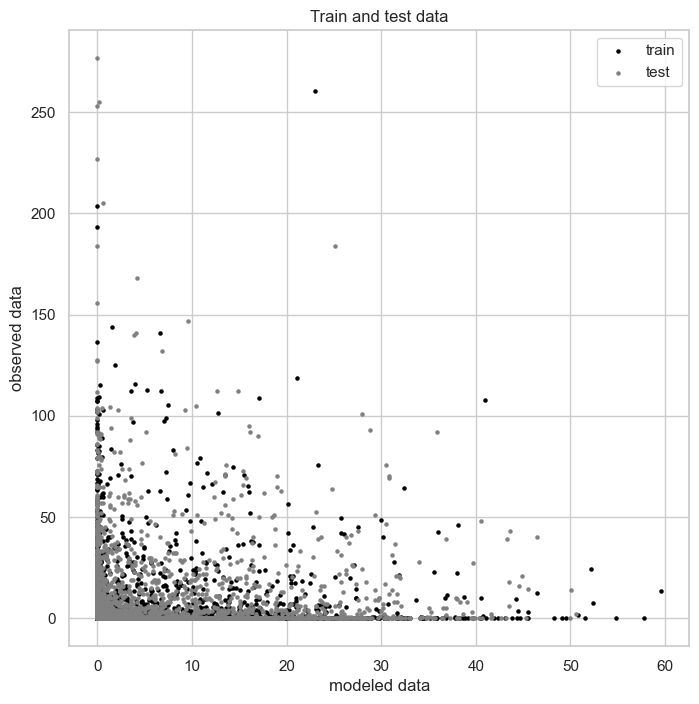

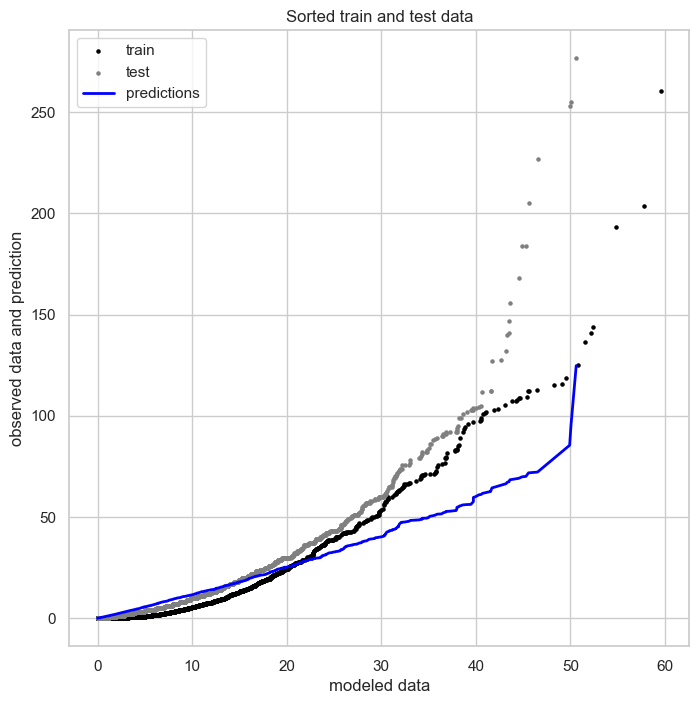

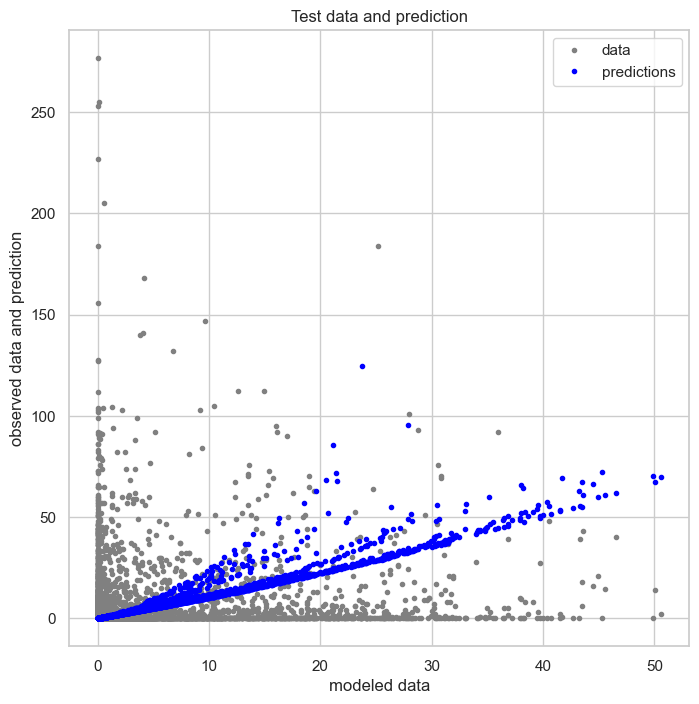

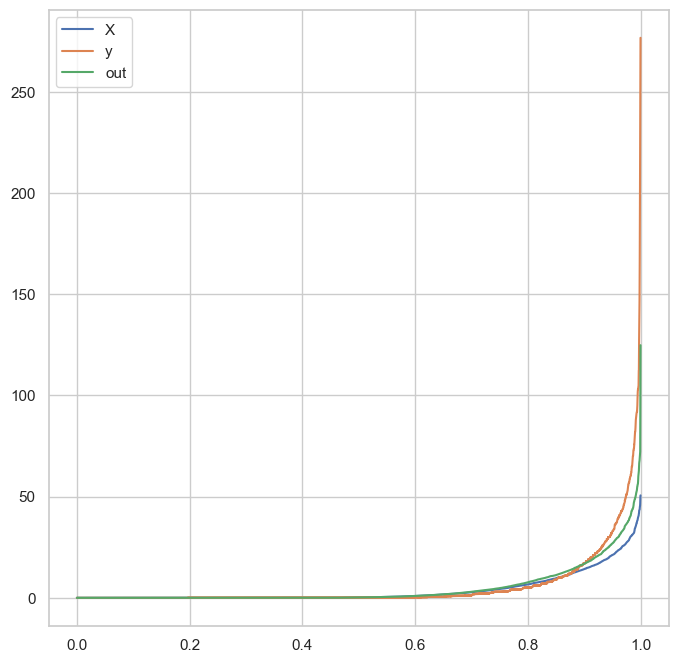

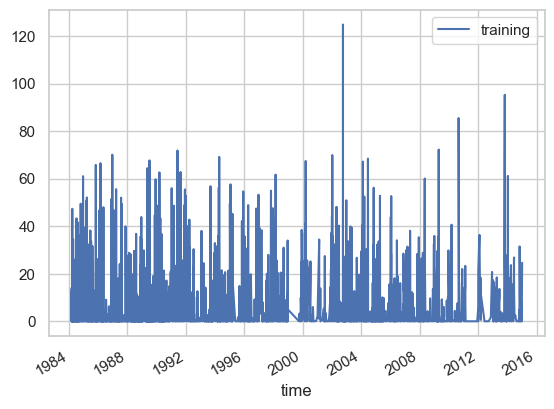

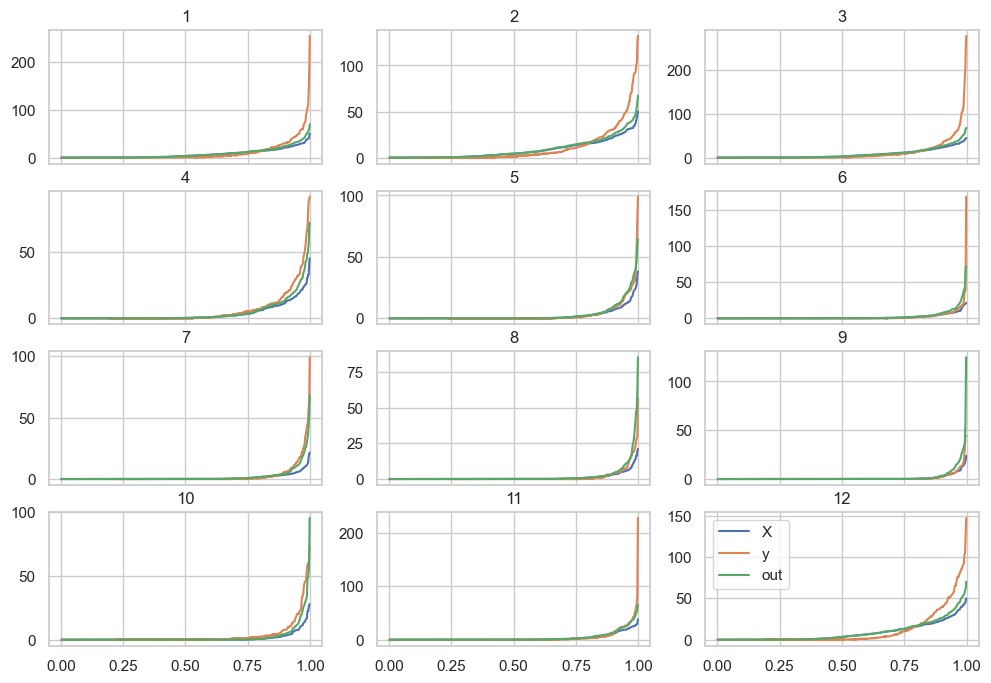

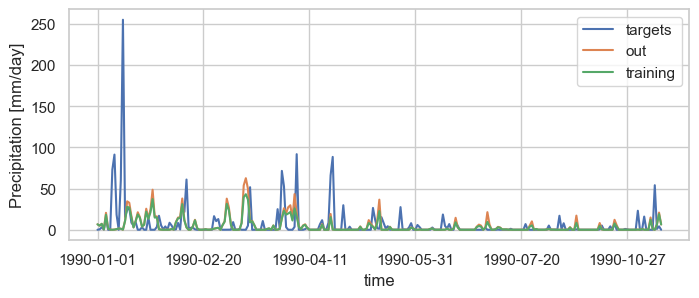

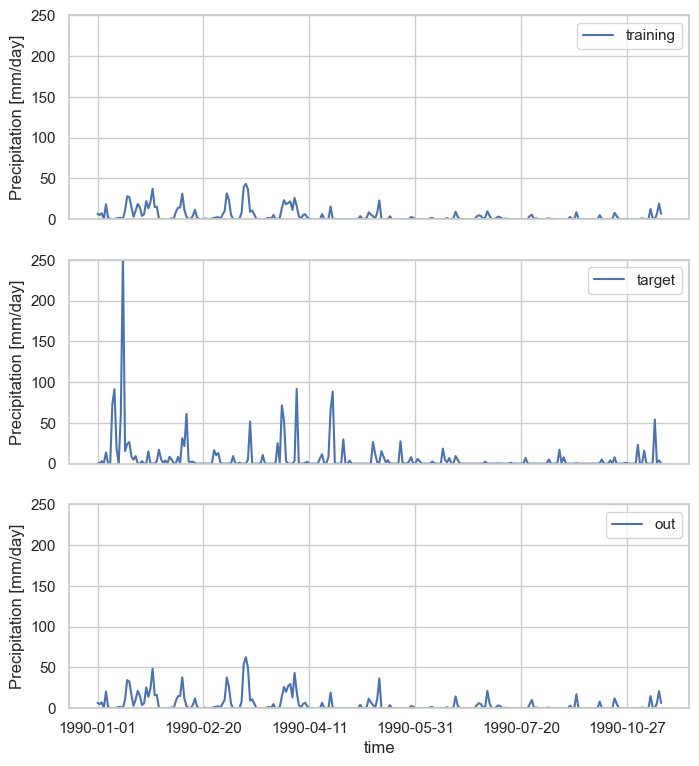

In [17]:
out=BCSD_Precipitation(df1)

             training targets
                  pcp     pcp
time                         
1984-03-01  13.850106     0.0
1984-03-02   6.081939     0.0
1984-03-03   9.124244     0.0
1984-03-04   4.856665     0.0
1984-03-05  12.263060     9.5
...               ...     ...
2014-12-16   0.000000     0.5
2014-12-17   0.095924    31.0
2014-12-18   0.272668     1.0
2014-12-19   0.050880     0.0
2014-12-31  24.635011     4.1

[5172 rows x 2 columns]
             training
                  pcp
time                 
1984-03-01  13.850106
1984-03-02   6.081939
1984-03-03   9.124244
1984-03-04   4.856665
1984-03-05  12.263060
...               ...
1992-05-29   0.000000
1992-05-30   0.000000
1992-05-31   0.000000
1992-06-04   0.000000
1992-06-05   0.000000

[2586 rows x 1 columns]
             training
                  pcp
time                 
1992-06-07   0.000000
1992-06-08   0.000000
1992-06-09   0.000000
1992-06-10   0.000000
1992-06-11   0.000000
...               ...
2014-12-16   0.000000
20

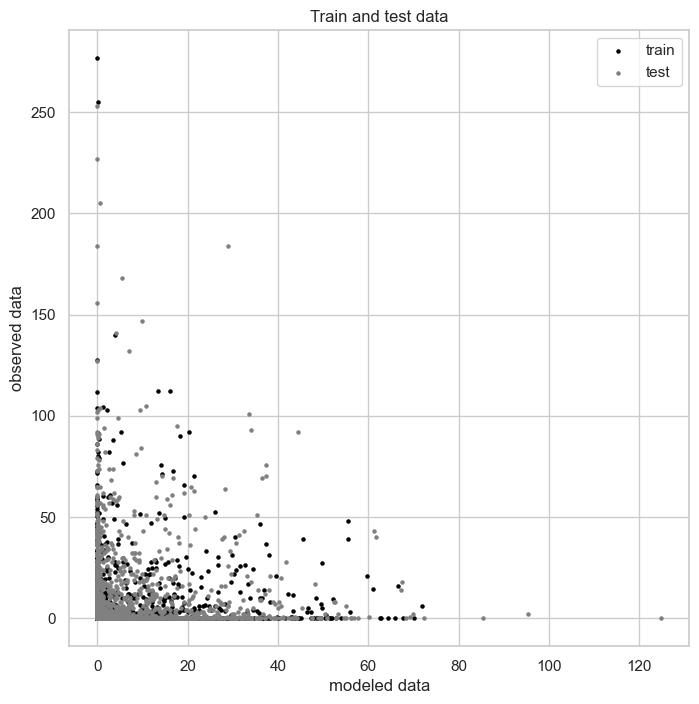

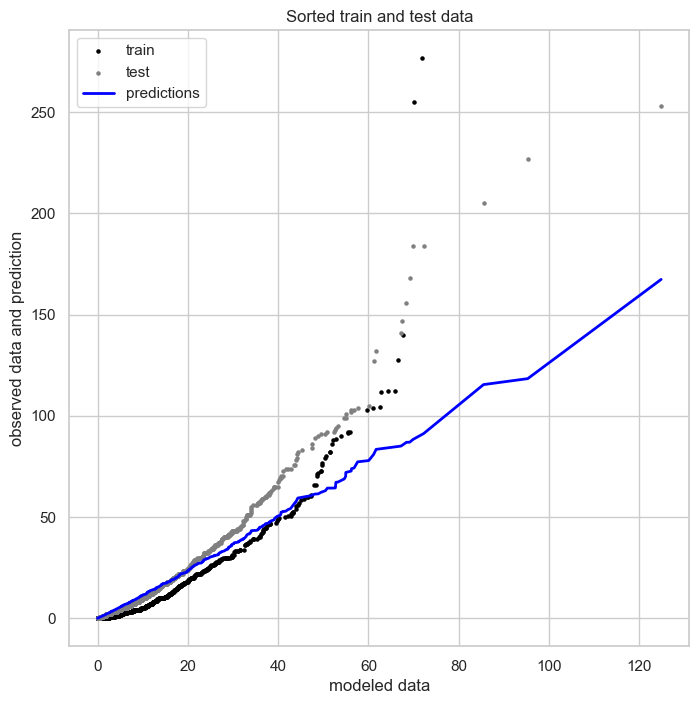

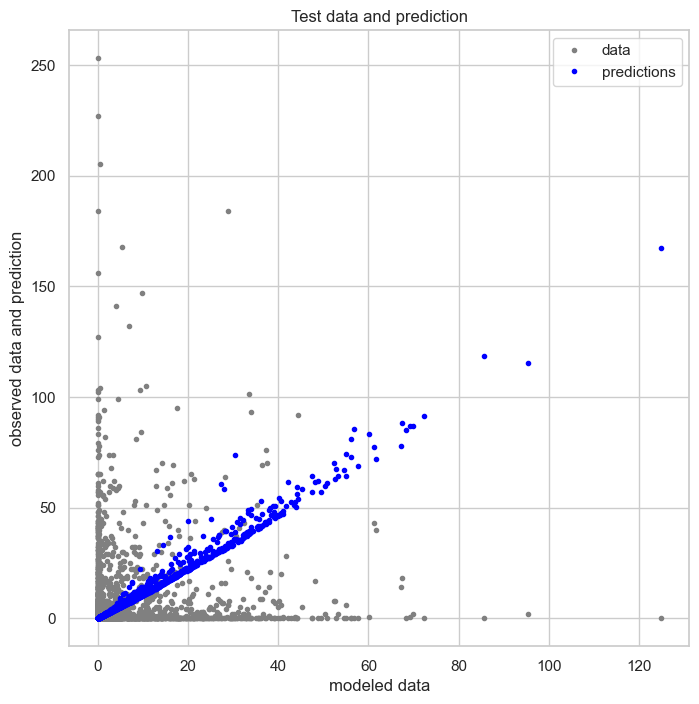

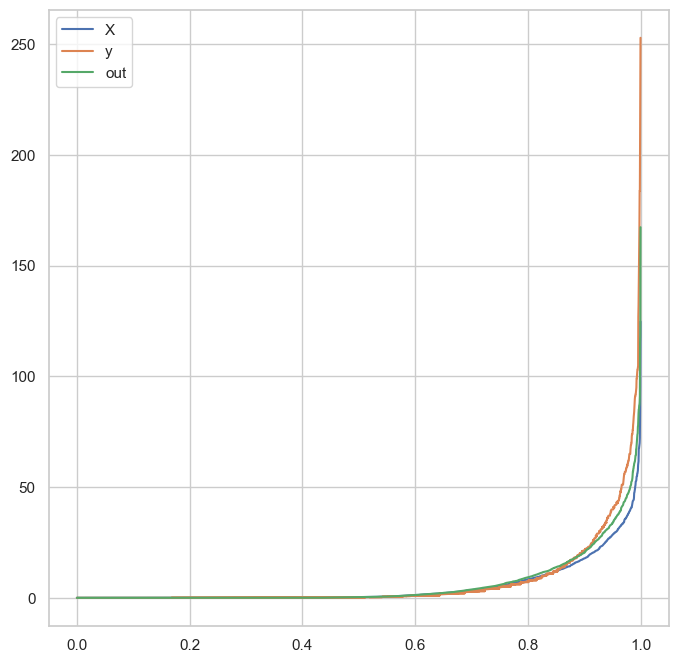

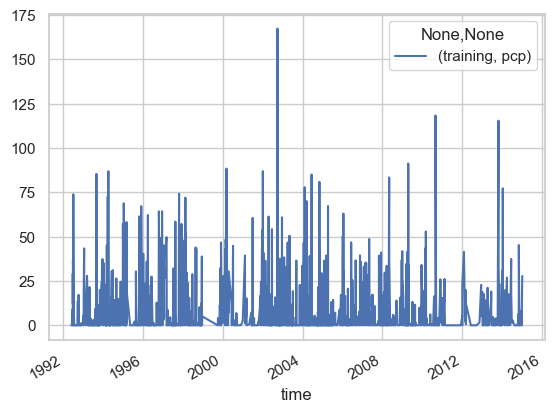

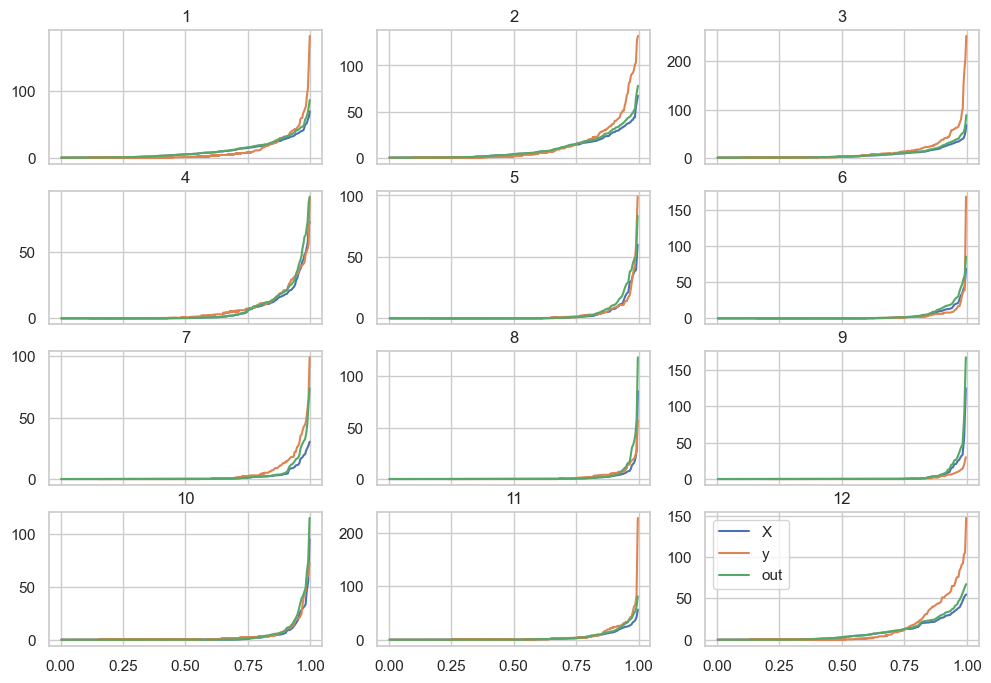

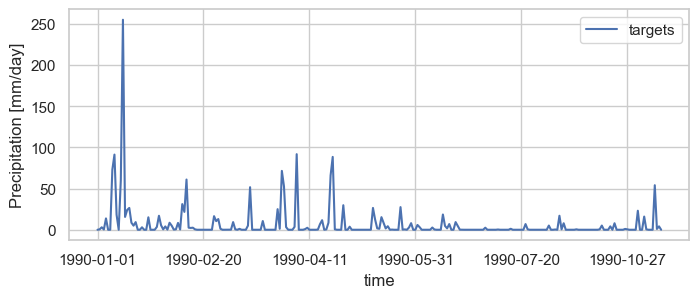

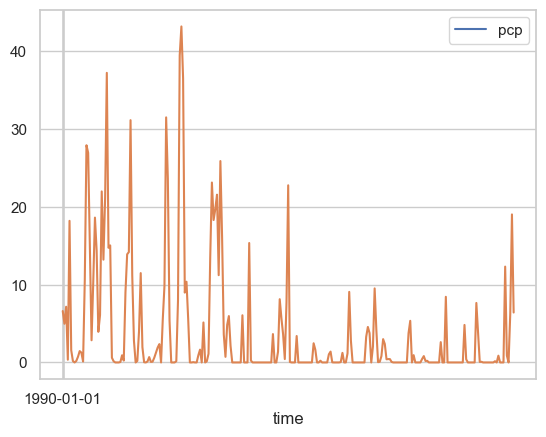

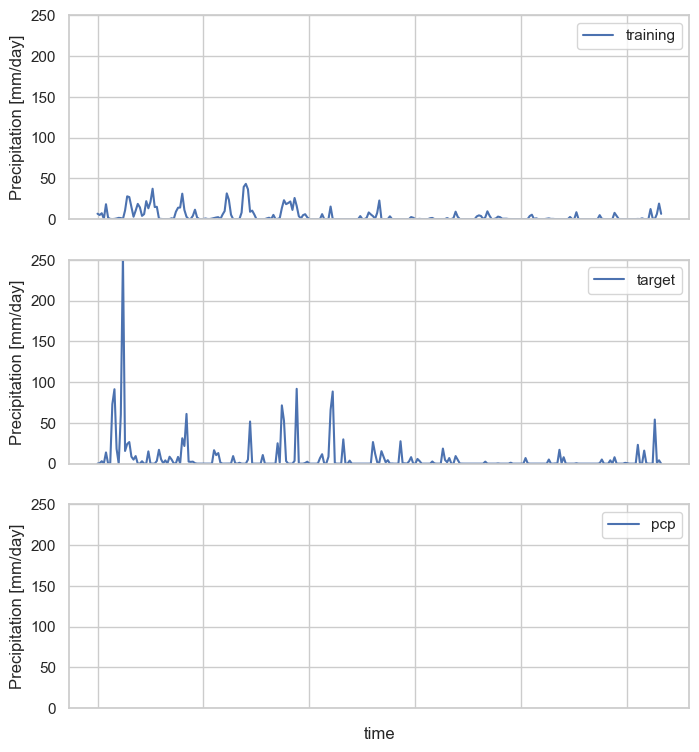

In [19]:
out=BCSD_Precipitation_one_more_time(df,out)

In [20]:
out

,pcp
,pcp
time,
1992-06-07,0.000000
1992-06-08,0.000000
1992-06-09,0.000000
1992-06-10,0.000000
1992-06-11,0.000000
...,...
2014-12-16,0.000000
2014-12-17,0.095924


             training targets
                  pcp     pcp
time                         
1992-06-07   0.000000     1.0
1992-06-08   0.000000     7.9
1992-06-09   0.000000    17.0
1992-06-10   0.000000     0.0
1992-06-11   0.000000     0.3
...               ...     ...
2014-12-16   0.000000     0.5
2014-12-17   0.095924    31.0
2014-12-18   0.272668     1.0
2014-12-19   0.050880     0.0
2014-12-31  27.836615     4.1

[2585 rows x 2 columns]
             training
                  pcp
time                 
1992-06-07   0.000000
1992-06-08   0.000000
1992-06-09   0.000000
1992-06-10   0.000000
1992-06-11   0.000000
...               ...
2003-01-03  10.412464
2003-01-06  22.439910
2003-01-09  10.871133
2003-01-10   5.901042
2003-01-11   0.402073

[1292 rows x 1 columns]
             training
                  pcp
time                 
2003-01-13   5.517157
2003-01-14   8.203642
2003-01-16   0.266990
2003-01-22   0.000000
2003-01-23   0.374284
...               ...
2014-12-16   0.000000
20

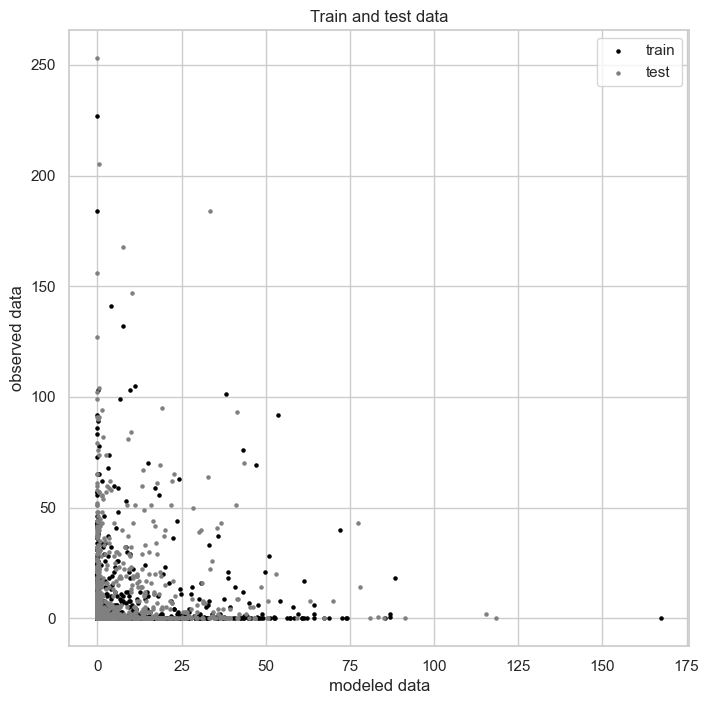

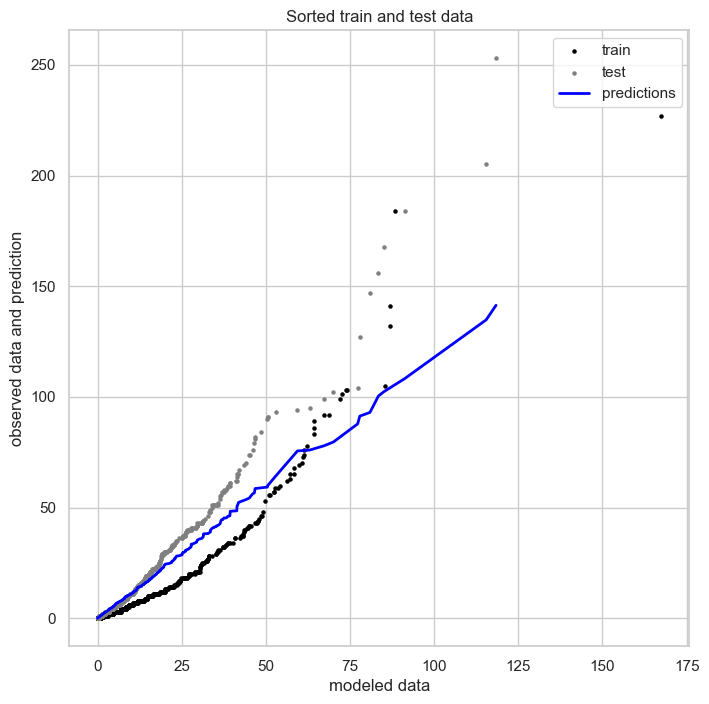

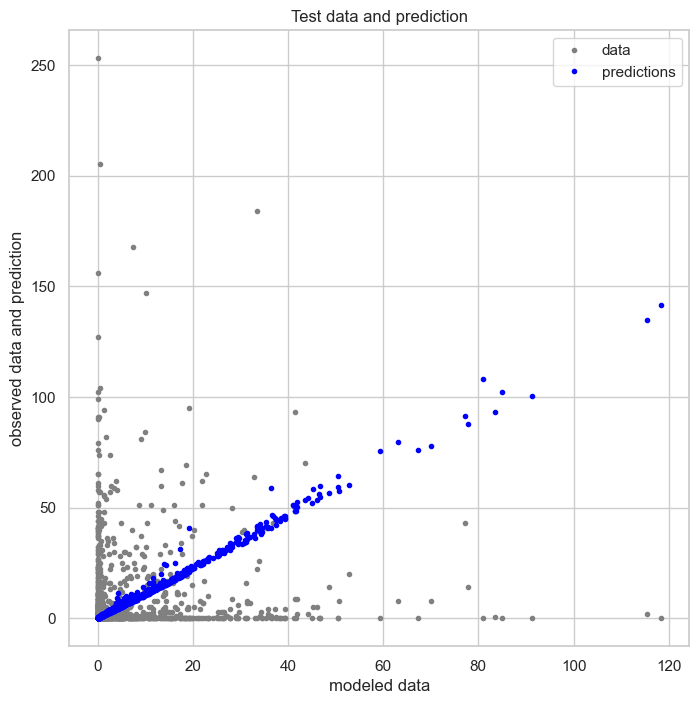

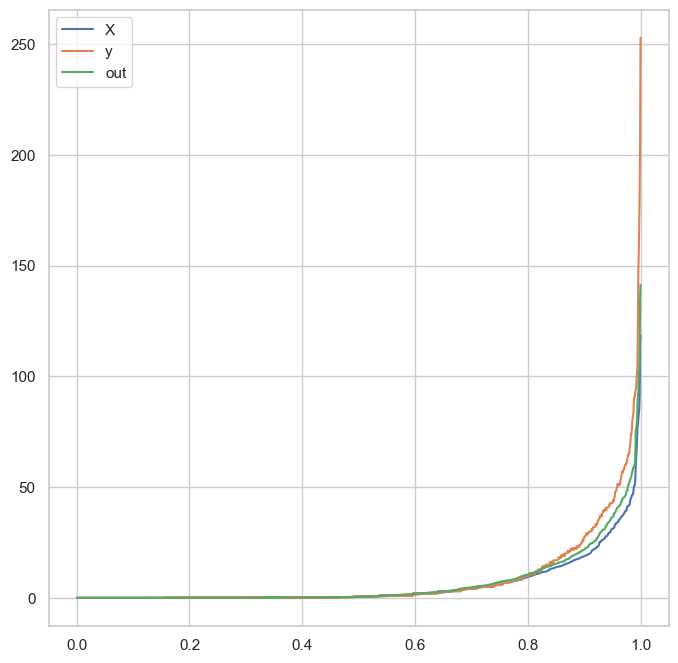

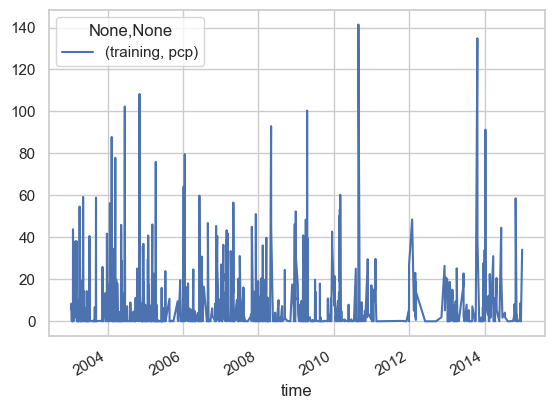

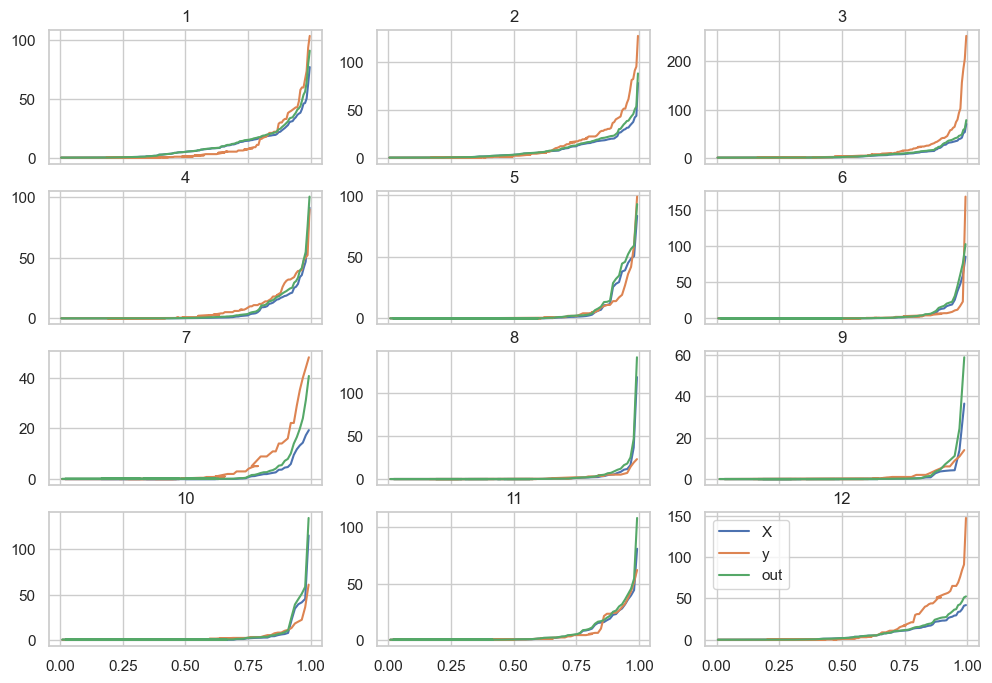

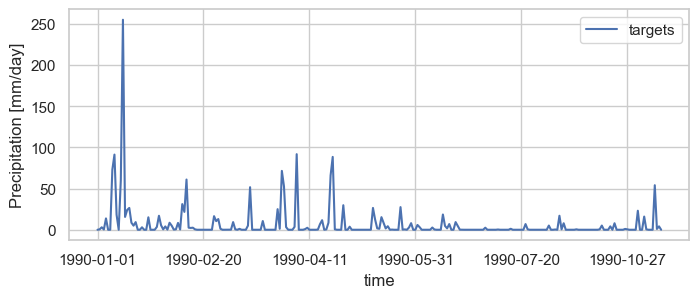

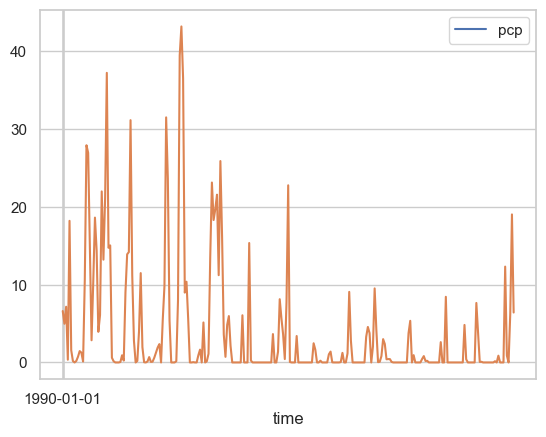

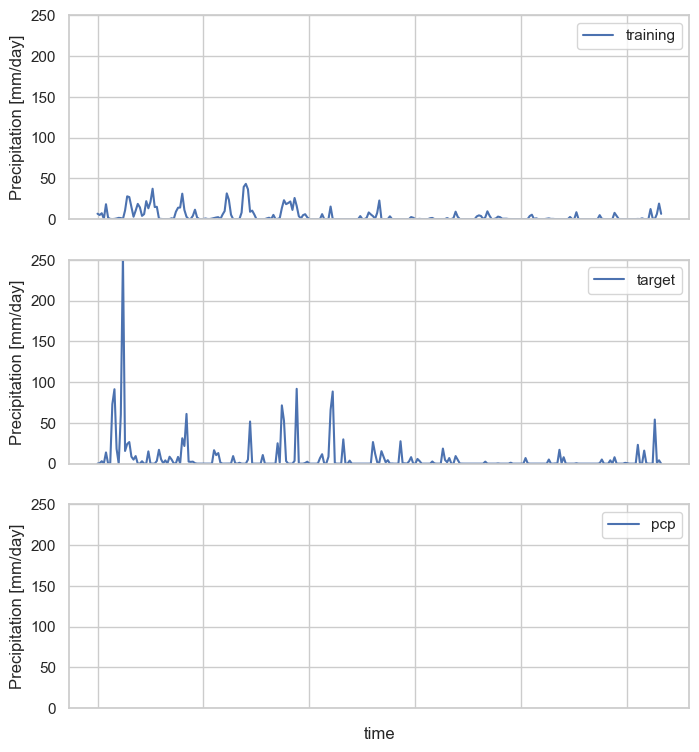

In [21]:
out=BCSD_Precipitation_one_more_time(df,out)

In [22]:
out

,pcp
,pcp
time,
2003-01-13,5.617303
2003-01-14,8.403934
2003-01-16,0.266990
2003-01-22,0.000000
2003-01-23,0.374284
...,...
2014-12-16,0.000000
2014-12-17,0.095924
